
# Deep Learning - Assigment 2 - Time Series Analysis <br>
Submmited By: Tal Ben Shimon, Shay Sitri



<p> 1.   Q1 - Data Analysis </p>
<p> 2.   Q2 - Time analysis Models
<ul>
a. Naiev Model <br>
c. Machine Leraning Model <br>
d. 1D-CNN  <br>
e. LSTM\GRU  <br>
</ul> </p>


In [18]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import pandas as pd
import os
from sklearn.calibration import LabelEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.calibration import LabelEncoder
from sklearn.metrics import accuracy_score
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
from sklearn.linear_model import LogisticRegression
import neptune
import torchvision.models as models
import pytorch_lightning as L
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from torchmetrics import Accuracy


# Data Analysis

First, we loaded the metadata.In this section, we will check the data distribution and see if there are some recurrent patterns that will help us to build models.

In [30]:
train_df = pd.read_csv("/content/Dataset/train.csv")

In [31]:
train_df

,Unnamed: 0,userid,activity,sensor,body_part,side,id,sequence_length
0,0,user01,stairs_up,smartwatch,hand,right,3387,3000
1,1,user01,walking_with_hands_in_pockets,smartwatch,hand,left,8473,4000
2,2,user08,walking_with_hands_in_pockets,smartwatch,hand,right,74365,3000
3,3,user01,walking_freely,smartwatch,hand,right,6223,3000
4,4,user07,using_phone,vicon,hand,left,61641,4000
...,...,...,...,...,...,...,...,...
50243,50243,user01,walking_with_hands_in_pockets,smartwatch,hand,right,8693,3500
50244,50244,user01,brushing_teeth,smartwatch,hand,right,161,3000
50245,50245,user01,washing_mug,smartwatch,hand,left,10239,3000
50246,50246,user03,walking_freely,vicon,hand,right,25386,4000


## Users Distribution

This plot describes the amount of activity that each user did. <br>
We can see, that it seems that the data is uniform distributed.

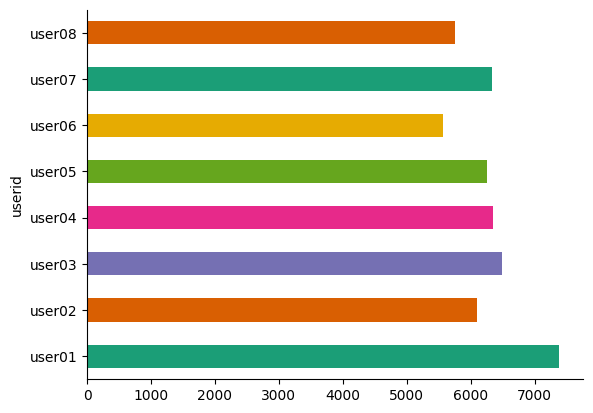

In [ ]:
train_df.groupby('userid').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

## Mesaurment Analysis
In this part, we tried to check how the movemnet on each axois look like for each of the activities. <br>
We normalized the data since the mesuremnts came from different sensors.

In [32]:
user1 = train_df.loc[train_df['userid'] == 'user01'].groupby('activity').first()['id'].values.tolist()
activity_list = train_df.loc[train_df['userid'] == 'user01'].groupby('activity')
activity_list = list(activity_list.groups.keys())

data = []
for i in range(len(activity_list)):
  activity = pd.read_csv('/content/Dataset/unlabeled/unlabeled/' + str(user1[i]) + '.csv')
  if 'measurement type' in activity.columns:
            activity = activity.loc[activity['measurement type'] == 'acceleration [m/s/s]'].drop(
                'measurement type', axis=1)
            activity = activity.rename(columns={"x": "x [m]", "y": "y [m]", "z" : "z [m]"})
  activity['activity'] = activity_list[i]
  data.append(activity)

In [ ]:
merged_data = pd.concat(data, ignore_index=False)
scaler = MinMaxScaler()

# Reshape 'x [m]' for scaling
x_m_values = merged_data['x [m]'].values.reshape(-1, 1)  # Reshaping is required for a single feature
y_m_values = merged_data['y [m]'].values.reshape(-1, 1)  # Reshaping is required for a single feature
z_m_values = merged_data['z [m]'].values.reshape(-1, 1)  # Reshaping is required for a single feature

# Scale 'x [m]' and replace in the dataframe
merged_data['x [m]_normalized'] = scaler.fit_transform(x_m_values)
merged_data['y [m]_normalized'] = scaler.fit_transform(y_m_values)
merged_data['z [m]_normalized'] = scaler.fit_transform(z_m_values)




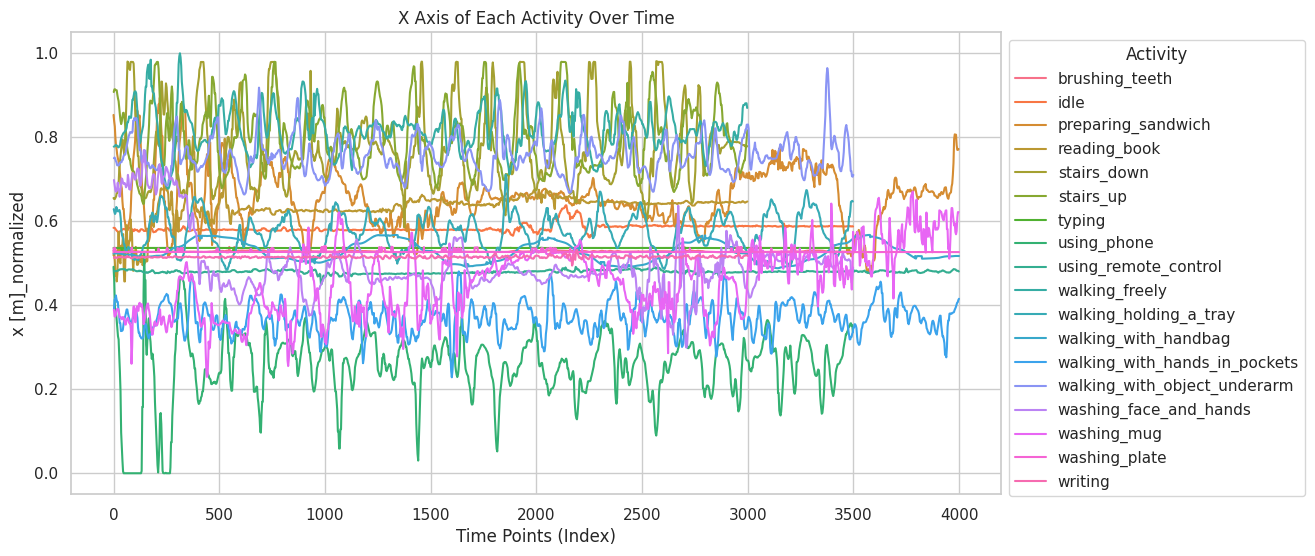

In [ ]:
sns.set(style="whitegrid")

# Assuming 'duration' is the column representing the duration of each activity
plt.figure(figsize=(12, 6))
sns.lineplot(x=merged_data.index, y='x [m]_normalized', hue='activity', data=merged_data)

plt.xlabel("Time Points (Index)")
plt.ylabel("x [m]_normalized")
plt.title("X Axis of Each Activity Over Time")
plt.legend(title='Activity', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

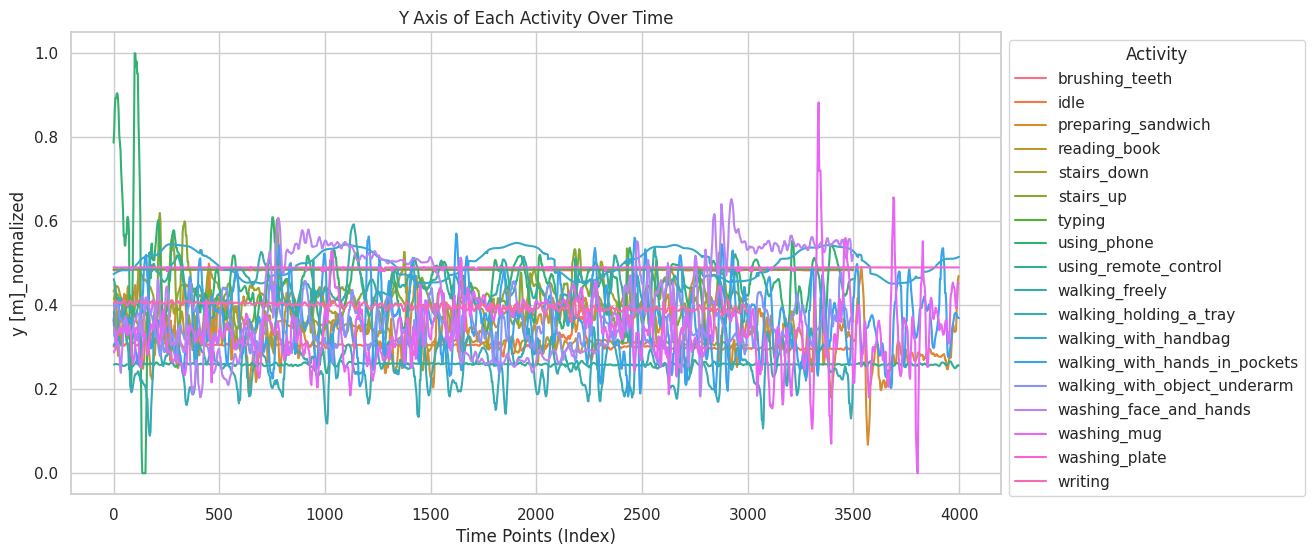

In [ ]:
sns.set(style="whitegrid")

# Assuming 'duration' is the column representing the duration of each activity
plt.figure(figsize=(12, 6))
sns.lineplot(x=merged_data.index, y='y [m]_normalized', hue='activity', data=merged_data)

plt.xlabel("Time Points (Index)")
plt.ylabel("y [m]_normalized")
plt.title("Y Axis of Each Activity Over Time")
plt.legend(title='Activity', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

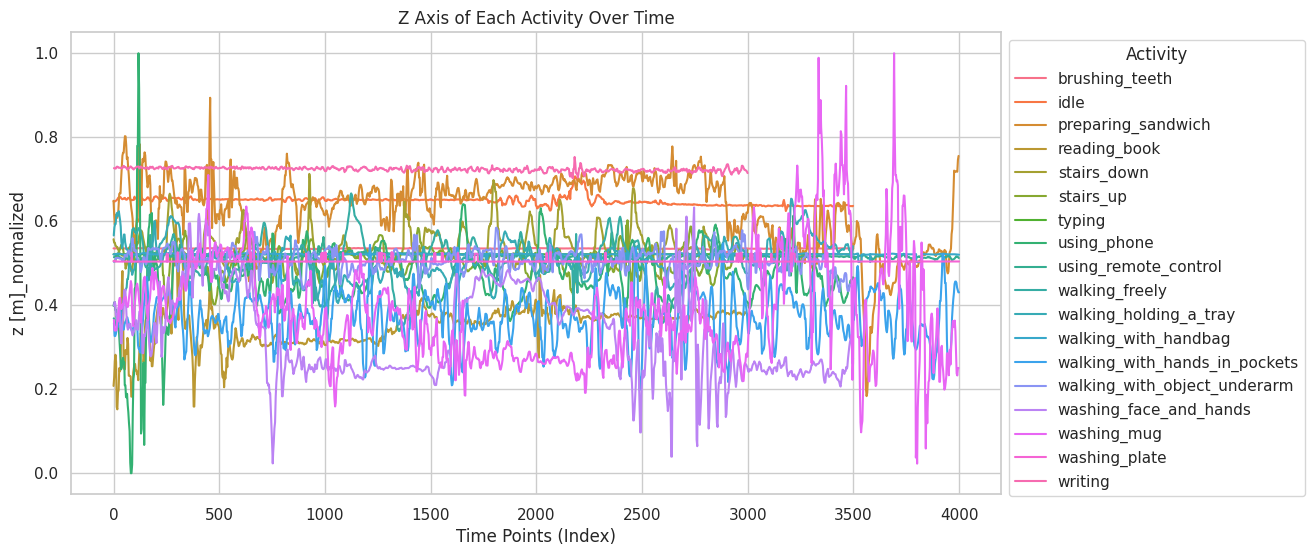

In [ ]:
sns.set(style="whitegrid")

# Assuming 'duration' is the column representing the duration of each activity
plt.figure(figsize=(12, 6))
sns.lineplot(x=merged_data.index, y='z [m]_normalized', hue='activity', data=merged_data)

plt.xlabel("Time Points (Index)")
plt.ylabel("z [m]_normalized")
plt.title("Z Axis of Each Activity Over Time")
plt.legend(title='Activity', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

## Activities Analysis


### Activities Distribution
This plot discribe the amouns of mesearues we have from each activity. We can see that the data is not uniformed distributed. Therefor we may considered to use stratify on data according label.

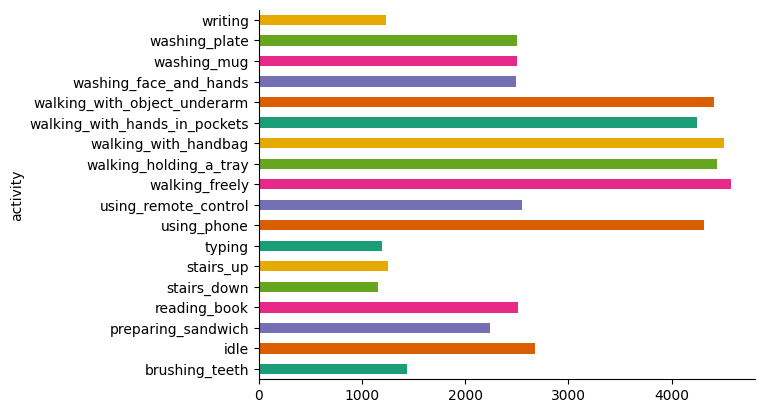

In [ ]:
train_df.groupby('activity').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

### Example 1 - 2 different activities
**Reading a Book VS Stairs Up** <br>
The first one, very static, could be some changes in the movment when a page is fliiped. <br>

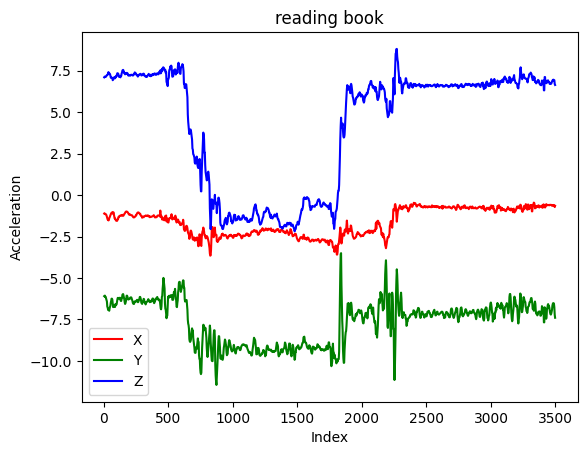

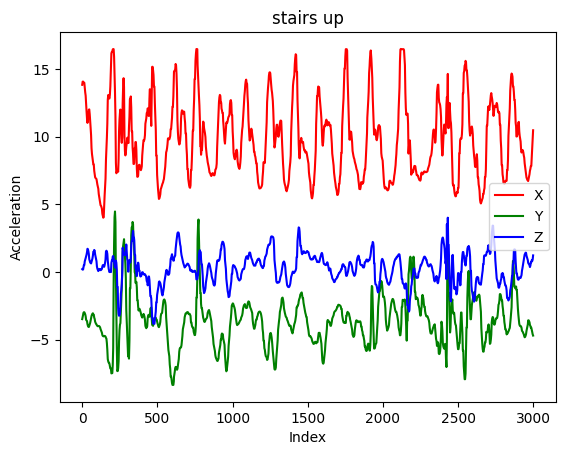

In [ ]:
train = pd.read_csv('/content/Dataset/train.csv')
# reading book
reading = train.loc[train['activity']=='reading_book']
data_file_reading = reading['id'][5]
data_pd_reading = pd.read_csv(f'/content/Dataset/unlabeled/unlabeled/{data_file_reading}.csv')
acceleration_data_reading = data_pd_reading.loc[data_pd_reading['measurement type']=='acceleration [m/s/s]']
acceleration_data_reading = acceleration_data_reading.drop('measurement type',axis=1)

plt.plot(acceleration_data_reading['x'], color='red', label='X')
plt.plot(acceleration_data_reading['y'], color='green', label='Y')
plt.plot(acceleration_data_reading['z'], color='blue', label='Z')
plt.xlabel('Index')
plt.ylabel('Acceleration')
plt.title('reading book')
plt.legend()

plt.show()

# stairs up
stairs = train.loc[train['activity']=='stairs_up']
data_file_stairs = stairs['id'][0]
data_pd_stairs = pd.read_csv(f'/content/Dataset/unlabeled/unlabeled/{data_file_stairs}.csv')
acceleration_data_stairs = data_pd_stairs.loc[data_pd_stairs['measurement type']=='acceleration [m/s/s]']
acceleration_data_stairs = acceleration_data_stairs.drop('measurement type',axis=1)

plt.plot(acceleration_data_stairs['x'], color='red', label='X')
plt.plot(acceleration_data_stairs['y'], color='green', label='Y')
plt.plot(acceleration_data_stairs['z'], color='blue', label='Z')
plt.xlabel('Index')
plt.ylabel('Acceleration')
plt.title('stairs up')
plt.legend()

plt.show()


### Example 2 - 2 similiar activites
**Walking Holding a Tray vs. Using Phone** <br>
We can see that to of the described activities are similiar. We infer that the similiar is due the close hand angle when holding a tray or using phone.

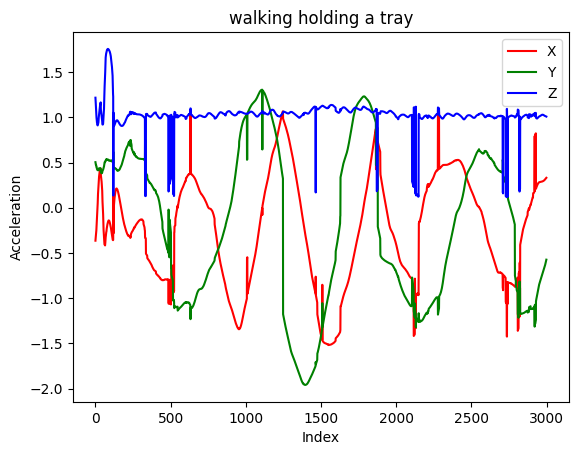

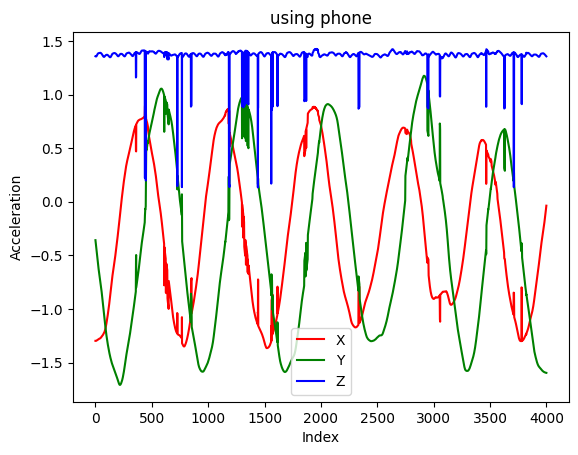

In [ ]:
# walking_holding_a_tray
tray = train.loc[train['activity']=='walking_holding_a_tray']
data_file_tray = tray['id'][226]
acceleration_data_tray = pd.read_csv(f'/content/Dataset/unlabeled/unlabeled/{data_file_tray}.csv')

plt.plot(acceleration_data_tray['x [m]'], color='red', label='X')
plt.plot(acceleration_data_tray['y [m]'], color='green', label='Y')
plt.plot(acceleration_data_tray['z [m]'], color='blue', label='Z')
plt.xlabel('Index')
plt.ylabel('Acceleration')
plt.title('walking holding a tray')
plt.legend()

plt.show()


# using phone

phone = train.loc[train['activity']=='using_phone']
data_file_phone = phone['id'][235]
acceleration_data_phone = pd.read_csv(f'/content/Dataset/unlabeled/unlabeled/{data_file_phone}.csv')

plt.plot(acceleration_data_phone['x [m]'], color='red', label='X')
plt.plot(acceleration_data_phone['y [m]'], color='green', label='Y')
plt.plot(acceleration_data_phone['z [m]'], color='blue', label='Z')
plt.xlabel('Index')
plt.ylabel('Acceleration')
plt.title('using phone')
plt.legend()

plt.show()

###Example 3 - Same activity, Different sensor
**Activity: Walking Holding a Tray**<br>
In this example we can see the extreme difference between the same activity that measured with different sensor.<br>
 We can see that the signal from the smartwatch has higher prequency Vs the vicon signal.

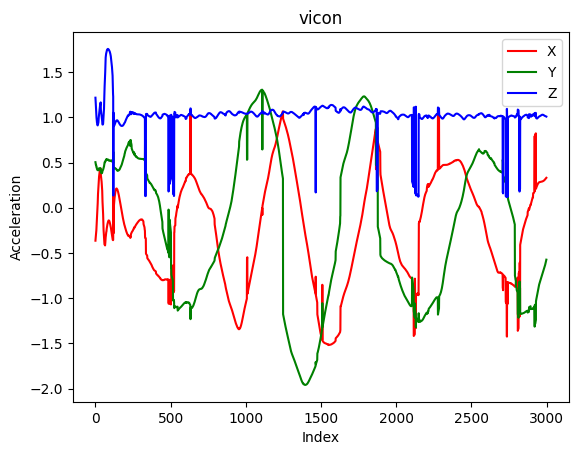

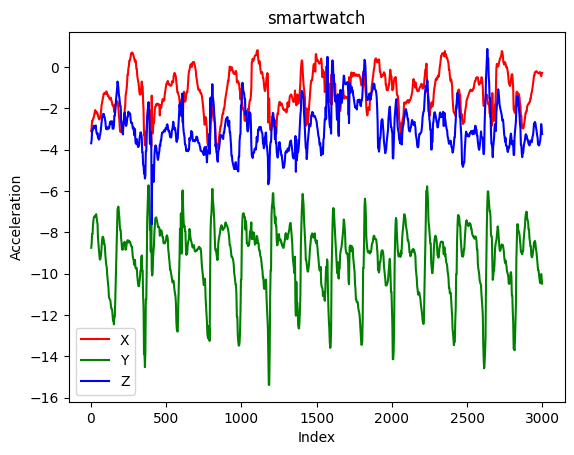

In [ ]:
# walking_holding_a_tray - vicon
tray_vicon = train.loc[train['activity']=='walking_holding_a_tray']
data_file_vicon = tray_vicon['id'][226]
acceleration_data_vicon = pd.read_csv(f'/content/Dataset/unlabeled/unlabeled/{data_file_vicon}.csv')

plt.plot(acceleration_data_vicon['x [m]'], color='red', label='X')
plt.plot(acceleration_data_vicon['y [m]'], color='green', label='Y')
plt.plot(acceleration_data_vicon['z [m]'], color='blue', label='Z')
plt.xlabel('Index')
plt.ylabel('Acceleration')
plt.title('vicon')
plt.legend()

plt.show()


# walking_holding_a_tray - smartwatch
tray_smartwatch = train.loc[train['activity']=='walking_holding_a_tray']
data_file_smartwatch = tray_smartwatch['id'][207]
data_pd_smartwatch = pd.read_csv(f'/content/Dataset/unlabeled/unlabeled/{data_file_smartwatch}.csv')

acceleration_data_smartwatch = data_pd_smartwatch.loc[data_pd_smartwatch['measurement type']=='acceleration [m/s/s]']
acceleration_data_smartwatch = acceleration_data_smartwatch.drop('measurement type',axis=1)

plt.plot(acceleration_data_smartwatch['x'], color='red', label='X')
plt.plot(acceleration_data_smartwatch['y'], color='green', label='Y')
plt.plot(acceleration_data_smartwatch['z'], color='blue', label='Z')
plt.xlabel('Index')
plt.ylabel('Acceleration')
plt.title('smartwatch')
plt.legend()

plt.show()




###Example 4 - Same activity, same Side, different body part
**Activity: washing a plate** <br>
**Sensor: Vicon** <br>
We can see, that in gerneral lines the signals are preety similiar. <br>
It is possible that the location of the sensor does not have too strong effect on the signals of the movement.

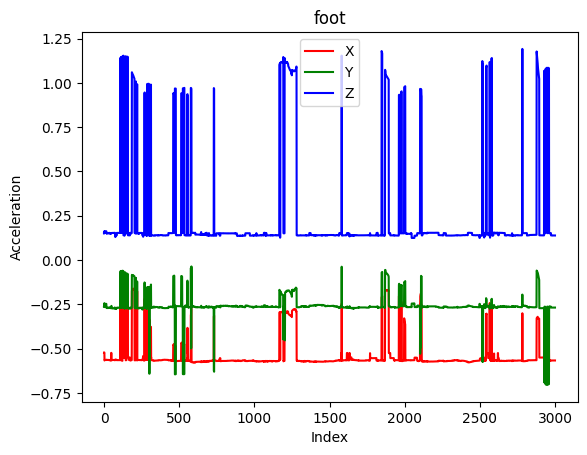

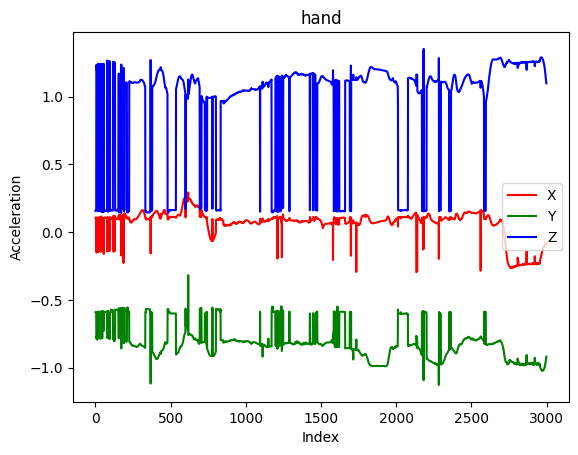

In [ ]:
# washing_plate - foot
foot = train.loc[train['activity']=='washing_plate']
data_file_foot = foot['id'][770]
data_pd_foot = pd.read_csv(f'/content/Dataset/unlabeled/unlabeled/{data_file_foot}.csv')

# acceleration_data_foot = data_pd_foot.loc[data_pd_foot['measurement type']=='acceleration [m/s/s]']
# acceleration_data_foot = acceleration_data_foot.drop('measurement type',axis=1)

plt.plot(data_pd_foot['x [m]'], color='red', label='X')
plt.plot(data_pd_foot['y [m]'], color='green', label='Y')
plt.plot(data_pd_foot['z [m]'], color='blue', label='Z')
plt.xlabel('Index')
plt.ylabel('Acceleration')
plt.title('foot')
plt.legend()

plt.show()


# washing_plate - hand
hand = train.loc[train['activity']=='washing_plate']
data_file_hand = hand['id'][742]
data_pd_hand = pd.read_csv(f'/content/Dataset/unlabeled/unlabeled/{data_file_hand}.csv')

# acceleration_data_foot = data_pd_foot.loc[data_pd_foot['measurement type']=='acceleration [m/s/s]']
# acceleration_data_foot = acceleration_data_foot.drop('measurement type',axis=1)

plt.plot(data_pd_hand['x [m]'], color='red', label='X')
plt.plot(data_pd_hand['y [m]'], color='green', label='Y')
plt.plot(data_pd_hand['z [m]'], color='blue', label='Z')
plt.xlabel('Index')
plt.ylabel('Acceleration')
plt.title('hand')
plt.legend()

plt.show()

###  Example 5 - Same Activity, Same Sensor, Different Side
From the plot, we can see that the signals from left and right sensors are bit different, but that their general shape is pretty similar.

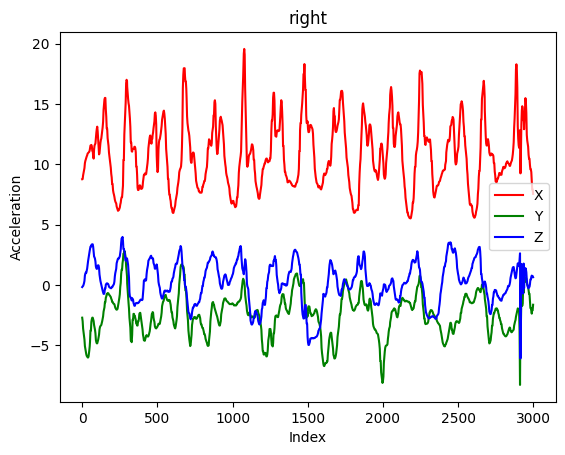

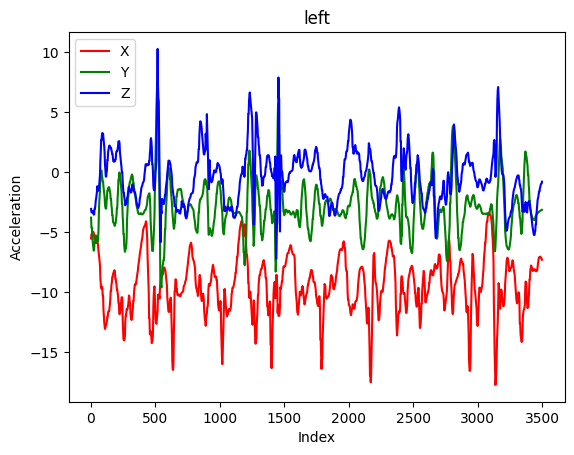

In [ ]:
# washing_plate - right
vicon = train.loc[train['activity']=='walking_freely']
data_file_vicon = vicon['id'][152]
data_pd_vicon = pd.read_csv(f'/content/Dataset/unlabeled/unlabeled/{data_file_vicon}.csv')

acceleration_data_foot = data_pd_vicon.loc[data_pd_vicon['measurement type']=='acceleration [m/s/s]']
acceleration_data_foot = acceleration_data_foot.drop('measurement type',axis=1)

plt.plot(acceleration_data_foot['x'], color='red', label='X')
plt.plot(acceleration_data_foot['y'], color='green', label='Y')
plt.plot(acceleration_data_foot['z'], color='blue', label='Z')
plt.xlabel('Index')
plt.ylabel('Acceleration')
plt.title('right')
plt.legend()

plt.show()


# washing_plate - left
smartwatch = train.loc[train['activity']=='walking_freely']
data_file_smartwatch = smartwatch['id'][279]
data_pd_smartwatch = pd.read_csv(f'/content/Dataset/unlabeled/unlabeled/{data_file_smartwatch}.csv')

acceleration_data_smartwatch = data_pd_smartwatch.loc[data_pd_smartwatch['measurement type']=='acceleration [m/s/s]']
acceleration_data_smartwatch = acceleration_data_smartwatch.drop('measurement type',axis=1)

plt.plot(acceleration_data_smartwatch['x'], color='red', label='X')
plt.plot(acceleration_data_smartwatch['y'], color='green', label='Y')
plt.plot(acceleration_data_smartwatch['z'], color='blue', label='Z')
plt.xlabel('Index')
plt.ylabel('Acceleration')
plt.title('left')
plt.legend()

plt.show()

###Example 6 - Same activity, Same Side, Same Bodypart, Same User, Different Sensor
**Activity: washing a plate** <br>
The purpose of this plot, was to check wether if the same user, that has its own movement signals, has similiar\different signals while performig an activity: "washing pkate".<br>
From the plot, we can see that although the movemnet has been done exactly the same, has extremly different signals, we can inffer that the sensor might have strong effect on the signal.

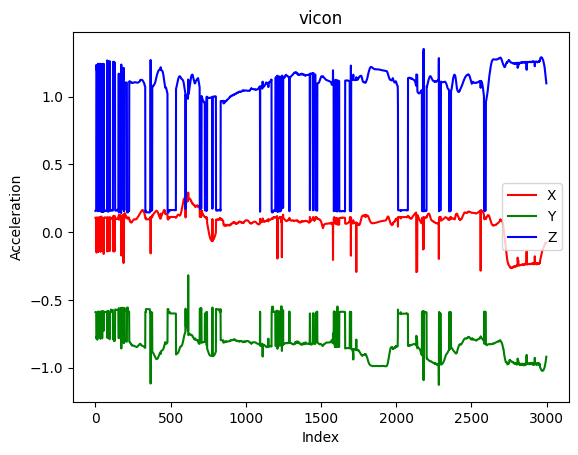

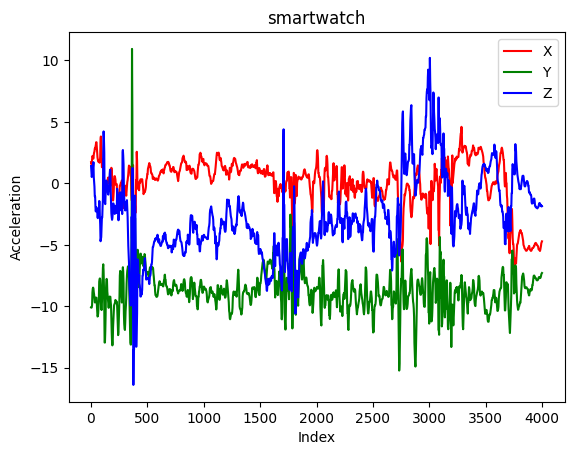

In [ ]:
# washing_plate - vicon
tray_vicon = train.loc[train['activity']=='washing_plate']
data_file_vicon = tray_vicon['id'][742]
acceleration_data_vicon = pd.read_csv(f'/content/Dataset/unlabeled/unlabeled/{data_file_vicon}.csv')

plt.plot(acceleration_data_vicon['x [m]'], color='red', label='X')
plt.plot(acceleration_data_vicon['y [m]'], color='green', label='Y')
plt.plot(acceleration_data_vicon['z [m]'], color='blue', label='Z')
plt.xlabel('Index')
plt.ylabel('Acceleration')
plt.title('vicon')
plt.legend()

plt.show()


# walking_holding_a_tray - smartwatch
tray_smartwatch = train.loc[train['activity']=='washing_plate']
data_file_smartwatch = tray_smartwatch['id'][710]
data_pd_smartwatch = pd.read_csv(f'/content/Dataset/unlabeled/unlabeled/{data_file_smartwatch}.csv')

acceleration_data_smartwatch = data_pd_smartwatch.loc[data_pd_smartwatch['measurement type']=='acceleration [m/s/s]']
acceleration_data_smartwatch = acceleration_data_smartwatch.drop('measurement type',axis=1)

plt.plot(acceleration_data_smartwatch['x'], color='red', label='X')
plt.plot(acceleration_data_smartwatch['y'], color='green', label='Y')
plt.plot(acceleration_data_smartwatch['z'], color='blue', label='Z')
plt.xlabel('Index')
plt.ylabel('Acceleration')
plt.title('smartwatch')
plt.legend()

plt.show()

## Files Type
There was 2 types of files - files contains another measurments except accleration.<br>
After dropping the irrelevant rows we notice that the data left for those file is much smaller than the file that doesnt contains accelartion. <br>
We can see, that the distribution of the files is uniformed for each activity.

In [7]:
summary_train_table = pd.read_csv("/content/summary_train_data.csv")

In [9]:
summary_train_table

,Unnamed: 0,id,type,num_of_rows,activity
0,0,3387,1,1007,5
1,1,8473,1,1340,12
2,2,74365,1,1002,12
3,3,6223,1,1003,9
4,4,61641,0,4000,7
...,...,...,...,...,...
50243,50243,8693,1,1172,12
50244,50244,161,1,1005,0
50245,50245,10239,1,1003,15
50246,50246,25386,0,4000,9


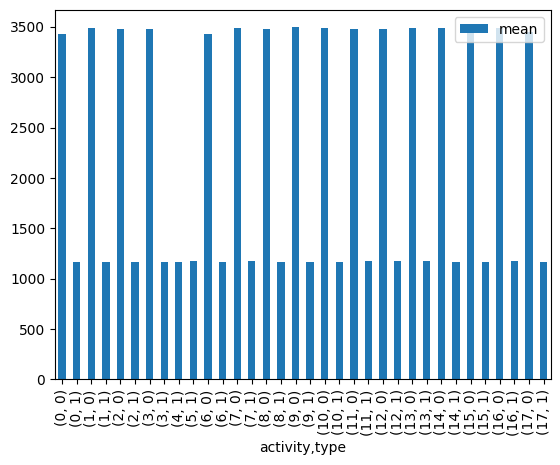

In [8]:
summary_train_table_grouped = summary_train_table.groupby(['activity','type']).describe()['num_of_rows']
summary_train_table_grouped
ax = summary_train_table_grouped.plot.bar(y='mean')

In [10]:
summary_test_table = pd.read_csv("/content/test_summary")

In [14]:
summary_test_table

,id,type,num_of_rows
0,1,1,1004
1,9,1,1001
2,12,1,1001
3,16,1,1001
4,17,1,1001
...,...,...,...
74739,124987,1,1338
74740,124988,1,1339
74741,124989,1,1340
74742,124990,1,1338


# Time Series Data Class

In [ ]:
class time_series_data(Dataset):
  def __init__(self, path_to_folder, labels, transform=None, target_transform=None, test=False):
      """
      :param path_to_folder: Folder of unlabeld files
      :param labels: Path to train.csv - contain train data
      :param transform:
      :param target_transform:
      """
      # read labels into df
      self.test = test
      self.labels_df = pd.read_csv(labels)
      self.path_to_folder = path_to_folder
      self.counter = 0
      le = LabelEncoder()
      encoded_label = le.fit_transform(self.labels_df['activity'])
      self.labels_df['activity'] = encoded_label
      self.ids = self.labels_df['id'].to_list()
  def __getitem__(self, idx):
      """
      :param idx: idx of unlabeld file
      :return: the time series data as np.array
      """
      path_to_file = self.path_to_folder + str(idx) + ".csv"
      file_data = pd.read_csv(path_to_file, engine='python')
      if 'measurement type' in file_data.columns:
          file_data = file_data.loc[file_data['measurement type'] == 'acceleration [m/s/s]'].drop(
              'measurement type', axis=1)
      if not self.test:
          idx_row = self.labels_df.loc[self.labels_df['id'] == idx]
          label = idx_row['activity'].to_list()[0]
          self.counter = self.counter + 1
      else:
          label = ""
      if self.counter % 100 == 0:
          print(self.counter)

      file_data = file_data.to_numpy()
      file_data = np.pad(file_data, pad_width=((0, 4000-len(file_data)), (0, 0)), mode='constant', constant_values=0)
      return file_data, label


In [ ]:
unlabeled_path = '/sise/home/sitri/hw2/Dataset/unlabeled/unlabeled/'
train_path = '/sise/home/sitri/hw2/Dataset/train.csv'
tsds = time_series_data(unlabeled_path, train_path)

In [ ]:
x_train = []
y_train = []

for id in tsds.ids:
    x, y = tsds[id]
    x_train.append(x)
    y_train.append(y)

x_train = np.transpose(x_train, (0, 2, 1))

np.save('/home/sitri/hw2/NEW_HW2/x_train_basic.npy', x_train)
np.save('/home/sitri/hw2/NEW_HW2/y_train_basic.npy', y_train)

tsds.test = True
x_test = []
test_path = pd.read_csv('hw2/sample_submission.csv')
test_id = test_path['sample_id'].to_list()

for id in test_id:
    x, y = tsds[id]
    x_test.append(x)


# x_test = np.transpose(x_test, (0, 2, 1))
x_test = np.load('/home/sitri/hw2/NEW_HW2/x_test.npy')
x_test = np.where(np.isnan(x_test), 0, x_test)

np.save('/home/sitri/hw2/NEW_HW2/x_test.npy', x_test)


#2.b: Naïve baseline

In [ ]:
# X_train, y_train for training features and labels
# X_val, y_val for validation features and labels
X_train = np.load('/home/sitri/hw2/Dataset/X_train.npy')
y_train = np.load('/home/sitri/hw2/Dataset/y_train.npy')
X_val = np.load('/home/sitri/hw2/Dataset/X_test.npy')
y_val = np.load('/home/sitri/hw2/Dataset/y_test.npy')

# Last Known Value Prediction
# For simplicity, we assume the last known value is the label of the last training example
last_known_value = y_train[-1]
y_pred_last_value = np.full(shape=y_val.shape, fill_value=last_known_value)
accuracy_last_value = accuracy_score(y_val, y_pred_last_value)
print(f'Accuracy of Last Known Value Prediction: {accuracy_last_value:.2f}')

# Majority Class Prediction
# Find the most common class in the training set

# Initialize the encoder
encoder = LabelEncoder()
# Fit the encoder and transform y_train to integer labels
y_train_encoded = encoder.fit_transform(y_train)
# Now, y_train_encoded can be used with np.bincount
majority_class = np.bincount(y_train_encoded).argmax()
# For predictions, ensure you transform y_val using the fitted encoder
y_val_encoded = encoder.transform(y_val)
# Now proceed with your original logic
y_pred_majority_class = np.full(shape=y_val_encoded.shape, fill_value=majority_class)
accuracy_majority_class = accuracy_score(y_val_encoded, y_pred_majority_class)
print(f'Accuracy of Majority Class Prediction: {accuracy_majority_class:.2f}')

#2.c: Random Forest
Since classical machine learning get input only in 1 dimension, we predicted the probabilities for each axis, using train-split validation with stratify on user id and activity.

In [ ]:
# Load the data
y_data = np.load('/home/sitri/hw2/NEW_HW2/y_train_basic.npy')
x_data = np.load('/home/sitri/hw2/NEW_HW2/x_train_basic.npy')

X_train_indices, X_val_indices, y_train, y_val = train_test_split(train_data['index'], train_data['activity'], test_size=0.3,
                                                    stratify=train_data[['activity','userid']])

# Generate the train and validation for x,y,z axis
x_train_x = [x_data[i][0] for i in X_train_indices]
x_train_y = [x_data[i][1] for i in X_train_indices]
x_train_z = [x_data[i][2] for i in X_train_indices]
x_val_x = [x_data[i][0] for i in X_val_indices]
x_val_y = [x_data[i][1] for i in X_val_indices]
x_val_z = [x_data[i][2] for i in X_val_indices]

# Generate the test for x,y,z axis
x_test = np.load('/home/sitri/hw2/NEW_HW2/x_test.npy')
x_test_x = [x_test[i][0] for i in range(0, len(x_test))]
x_test_y = [x_test[i][1] for i in range(0, len(x_test))]
x_test_z = [x_test[i][2] for i in range(0, len(x_test))]

clf = RandomForestClassifier()

# Fit on X-Axis
clf.fit(x_train_x, y_train)
accuracy1 = clf.score(x_val_x, y_val)
probs_x = clf.predict_proba(x_test_x)
result_df = pd.DataFrame(probs_x, columns=[f'Class_{i}' for i in range(probs_x.shape[1])])
result_df.to_csv('/home/sitri/hw2/NEW_HW2/random_forest_x.csv', index=True)

# Fit on Y-Axis
clf.fit(x_train_y, y_train)
accuracy2 = clf.score(x_val_y, y_val)
probs_y = clf.predict_proba(x_test_y)
result_df = pd.DataFrame(probs_y, columns=[f'Class_{i}' for i in range(probs_y.shape[1])])
result_df.to_csv('/home/sitri/hw2/NEW_HW2/random_forest_y.csv', index=True)

# Fit on Z-Axis
clf.fit(x_train_z, y_train)
accuracy3 = clf.score(x_val_z, y_val)
probs_z = clf.predict_proba(x_test_z)
result_df = pd.DataFrame(probs_z, columns=[f'Class_{i}' for i in range(probs_z.shape[1])])
result_df.to_csv('/home/sitri/hw2/NEW_HW2/random_forest_z.csv', index=True)

# Calculate the mean probabilities for the test
probs_x = pd.read_csv('/home/sitri/hw2/NEW_HW2/random_forest_x.csv', index_col=0)
probs_y = pd.read_csv('/home/sitri/hw2/NEW_HW2/random_forest_y.csv', index_col=0)
probs_z = pd.read_csv('/home/sitri/hw2/NEW_HW2/random_forest_z.csv', index_col=0)

# Calculate the average probabilities across dimensions
average_probs = (probs_x + probs_y + probs_z) / 3

# Save the average probabilities to a new CSV file
average_probs.to_csv('/home/sitri/hw2/NEW_HW2/random_forest_average.csv', index=True)


**Accuracy Output on Validation:** <br>
X-Axis: 0.843648424543947 <br>
Y-Axis: 0.8285240464344942 <br>
Z-Axis: 0.8260033167495854

#2.d.0: Preprocess for models data
Each row was padded according to its actual size. For example, if the row length after dropout irrelevant rows its 1000, so it split for 2 halvs: each of size 500. The first half, is padding from the left - [0,0,...0, -- data --], and the other half is padding from the right - [-- data -- , 0,0,..0].


> * **All the models we build at this section used this data.**




In [ ]:
unlabeled_path = '/sise/home/sitri/hw2/Dataset/unlabeled/unlabeled/'
train_path = '/sise/home/sitri/hw2/Dataset/train.csv'
tsds = time_series_data(unlabeled_path, train_path)

# x_train, x_test - contains the actual data of labeld and unlabeld files.
# y_train - contains the labels of x_train.
x_train = np.load('/home/sitri/hw2/NEW_HW2/x_train_basic.npy')
y_train = np.load('/home/sitri/hw2/NEW_HW2/y_train_basic.npy')
x_test = np.load('/home/sitri/hw2/NEW_HW2/x_test.npy')
x_train = np.transpose(x_train, (0, 2, 1))
x_test = np.transpose(x_test, (0, 2, 1))

# getthe length without read the file again
seq_length_list_train = pd.read_csv('/home/sitri/hw2/summary_train_data.csv')['num_of_rows'].tolist()
seq_length_list_test = pd.read_csv('/home/sitri/hw2/test_summary')['num_of_rows'].tolist()
test_id = pd.read_csv('/home/sitri/hw2/test_summary')['id'].tolist()

# Create train data (y is the same, we keep the order of the x_train)
train_data_padded = []
for i in range(0,len(x_train)):
    seq_len = seq_length_list_train[i]
    item = x_train[i][0 : seq_len]
    split = len(item)// 2
    left_part = item[ : split]
    right_part = item[split : ]
    left_part = np.pad(left_part, ((2000 - len(left_part), 0), (0, 0)), 'constant', constant_values=0)
    right_part = np.pad(right_part, ((0, 2000 - len(right_part)), (0, 0)), 'constant', constant_values=0)
    complete = np.concatenate([left_part, right_part], axis=0)
    train_data_padded.append(complete)

train_data_padded = np.array(train_data_padded)
np.save('/home/sitri/hw2/NEW_HW2/merge__autoencoder2_train_x_1.npy', train_data_padded)

# Create test data
test_data_padded = []
for i in range(0,len(x_test)):
    seq_len = seq_length_list_test[i]
    item = x_test[i][0 : seq_len]
    split = len(item)// 2
    left_part = item[ : split]
    right_part = item[split : ]
    left_part = np.pad(left_part, ((2000 - len(left_part), 0), (0, 0)), 'constant', constant_values=0)
    right_part = np.pad(right_part, ((0, 2000 - len(right_part)), (0, 0)), 'constant', constant_values=0)
    complete = np.concatenate([left_part, right_part], axis=0)
    test_data_padded.append(complete)

test_data_padded = np.array(test_data_padded)
np.save('/home/sitri/hw2/NEW_HW2/merge__autoencoder2_test_x_1.npy', test_data_padded)

# create train set and validation set for the transfer leraning part using test-spli of 70-30

train_relevant = tsds.labels_df[['id', 'activity']]
X_train, X_test, y_train, y_test = train_test_split(train_relevant['id'], train_relevant['activity'], test_size=0.3,
                                                    stratify=train_relevant['activity'])
train_data_x = []
val_data_x = []
train_data_y = []
val_data_y = []

for id in X_train:
    i = tsds.ids.index(id)
    train_data_x.append(train_data[i])
    train_data_y.append(y_data[i])

for id in X_test:
    i = tsds.ids.index(id)
    val_data_x.append(train_data[i])
    val_data_y.append(y_data[i])

train_data_x = np.array(train_data_x)
val_data_x = np.array(val_data_x)
train_data_y = np.array(train_data_y)
val_data_y = np.array(val_data_y)

np.save("/sise/home/sitri/hw2/NEW_HW2/merge__autoencoder_train_x_70.npy", train_data_x)
np.save("/sise/home/sitri/hw2/NEW_HW2/merge__autoencoder_train_y_70.npy", train_data_y)
np.save("/sise/home/sitri/hw2/NEW_HW2/merge__autoencoder_val_x_70.npy", val_data_x)
np.save("/sise/home/sitri/hw2/NEW_HW2/merge__autoencoder_val_y_70.npy", val_data_y)

In [ ]:
X_data = np.load("/home/sitri/hw2/NEW_HW2/merge__autoencoder2_train_x_1.npy")
X_test = np.load("/sise/home/sitri/hw2/NEW_HW2/merge__autoencoder_test_x_1.npy")
#################

x_train_after_split = np.load("/sise/home/sitri/hw2/NEW_HW2/merge__autoencoder_train_x_70.npy")
y_train_after_split = np.load("/sise/home/sitri/hw2/NEW_HW2/merge__autoencoder_train_y_70.npy")
x_val_after_split = np.load("/sise/home/sitri/hw2/NEW_HW2/merge__autoencoder_val_x_70.npy")
y_val_after_split = np.load("/sise/home/sitri/hw2/NEW_HW2/merge__autoencoder_val_y_70.npy")

x_train_tensor = torch.tensor(X_data, dtype=torch.float32)
train_dataset = TensorDataset(x_train_tensor, x_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=False)
#################

x_train_after_split = torch.tensor(x_train_after_split, dtype=torch.float32)
y_train_after_split = torch.tensor(y_train_after_split, dtype=torch.int64)
train_after_split_dataset = TensorDataset(x_train_after_split, y_train_after_split)
train_after_split_dataloader = DataLoader(train_after_split_dataset, batch_size=64, shuffle=False)
#################

x_val_after_split = torch.tensor(x_val_after_split, dtype=torch.float32)
y_val_after_split = torch.tensor(y_val_after_split, dtype=torch.int64)
val_dataset = TensorDataset(x_val_after_split, y_val_after_split)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
#################

X_test = torch.tensor(X_test, dtype=torch.float32)
n_samples = X_test.size(0)
dummy_labels_tensor = torch.zeros(n_samples, dtype=torch.long)
test_dataset1 = TensorDataset(X_test,dummy_labels_tensor)
test_dataloader = DataLoader(test_dataset1, batch_size=64, shuffle=False)

#2.d.1: 1D-CNN


In [ ]:
class CNN1DModel(L.LightningModule):
    def __init__(self, input_channels, n_classes, dims=None, val=None):
        super(CNN1DModel, self).__init__()
        self.layer1 = torch.nn.Conv1d(in_channels=input_channels, out_channels=3, kernel_size=1, stride=1)
        self.layer2 = torch.nn.Conv1d(in_channels=3, out_channels=16, kernel_size=3, stride=1)
        self.layer3 = torch.nn.Conv1d(in_channels=16, out_channels=64, kernel_size=5, stride=1)
        self.flatten = torch.nn.Flatten()
        self.mp = torch.nn.MaxPool1d(2)
        self.loss = torch.nn.CrossEntropyLoss()
        self.val_dataset = val
        self.batch_size = 64
        self.accuracy = Accuracy(task="multiclass", num_classes=18)
        self.probs = []
        self.n_classes = n_classes
        self.fc = torch.nn.Linear(497 * 64, n_classes)
        self.train_accuracy = Accuracy(task="multiclass", num_classes=n_classes)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=n_classes)
        self.validation_output = {}
        self.epoch = 0

    def forward(self, x):
        x = torch.nn.functional.relu(self.layer1(x))
        x= self.mp(x)
        x = torch.nn.functional.relu(self.layer2(x))
        x= self.mp(x)
        x = torch.nn.functional.relu(self.layer3(x))
        x= self.mp(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

    def training_step(self, batch, batch_idx):

        x, y = batch
        logits = self(x)
        loss = self.loss(logits, y)
        self.log('train_loss', loss,prog_bar=True)
        preds = torch.argmax(logits, dim=1)
        self.train_accuracy.update(preds, y)
        preds_probs = F.softmax(logits, dim=1)
        preds_probs = preds_probs.detach().cpu().numpy()
        np.save("/home/sitri/hw2/NEW_HW2/pred_probs_train_1.npy", preds_probs)
        accuracy_value = self.train_accuracy.compute()
        run['train_loss'].append(loss.item())
        run['train_acc'].append(accuracy_value)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.val_accuracy.update(preds, y)
        self.log('val_loss', loss,prog_bar=True)
        preds = torch.argmax(logits, dim=1)
        #self.log('val_acc', self.accuracy(preds, y), on_step=False, on_epoch=True, prog_bar=True)
        print(f'Validation Accuracy : {self.accuracy(preds, y)}')
        preds_probs = F.softmax(logits, dim=1)
        # concat preds and y values from the batches of the epoch
        preds_df = pd.concat([self.validation_output['preds'], pd.DataFrame(data=preds.detach().cpu().numpy())])
        self.validation_output['preds'] = preds_df
        y_df = pd.concat([self.validation_output['y'], pd.DataFrame(data=y.detach().cpu().numpy())])
        self.validation_output['y'] = y_df

        df_batch = pd.DataFrame(data={'y_test': y.cpu().numpy(),
                                      'y_pred': preds.cpu().numpy(),
                                      'y_pred_probability': preds_probs.max(dim=1)[0].detach().cpu().numpy()})
        self.validation_output['preds_report'] = pd.concat([self.validation_output['preds_report'], df_batch])

        preds_probs = preds_probs.detach().cpu().numpy()
        accuracy_value = self.val_accuracy.compute()
        run['val_loss'].append(loss.item())
        run['val_acc'].append(accuracy_value)
        np.save("/home/sitri/hw2/NEW_HW2/pred_probs_val_1.npy", preds_probs)

    def test_step(self, batch, batch_idx):
        x, _ = batch  # Labels are dummy since test set might be unlabeled
        logits = self(x)
        probabilities = torch.nn.functional.softmax(logits, dim=1)
        print(probabilities)
        self.probs.append(probabilities)
        return probabilities

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def on_train_epoch_end(self):
        self.epoch += 1

    def on_validation_epoch_start(self):
    ## initiate validation data, for calculating on the relevant inforamtion at the end of the epoch.
        print('validation epoch start')
        self.validation_output['preds'] = pd.DataFrame(data=[])
        self.validation_output['preds_report'] = pd.DataFrame(
            data={'id': [], 'y_test': [], 'y_pred': [], 'y_pred_probability': []})
        self.validation_output['y'] = pd.DataFrame(data=[])

    # Inside the on_validation_epoch_end method
    def on_validation_epoch_end(self):
        print("Validation Output Shapes:")
        print("y shape:", self.validation_output['y'].shape)
        print("preds shape:", self.validation_output['preds'].shape)

        # Ensure y and preds are converted to NumPy arrays if they are PyTorch tensors
        y = self.validation_output['y'].to_numpy().flatten()
        preds = self.validation_output['preds'].to_numpy().flatten()
        run[f'val/preds_repoert_{self.epoch}'] = neptune.types.File.as_html(self.validation_output['preds_report'])
        # Calculate classification report
        report = classification_report(y, preds, output_dict=True)
        df_report = pd.DataFrame.from_dict(report)
        df_report.to_csv(f'/home/sitri/hw2/NEW_HW2/validation_report_{self.epoch}_1.csv', index=False, header=True)
        run[f'val/metrics_{self.epoch}'] = neptune.types.File.as_html(df_report)


    def on_test_epoch_end(self):
        # Concatenate along the batch dimension (dim=0)
        all_probs = torch.cat(self.probs, dim=0)
        print(all_probs)
        test_probs = all_probs.detach().cpu().numpy()
        print(test_probs)
        np.save("/home/sitri/hw2/NEW_HW2/test_probs_cnn_1.npy", test_probs)

In [ ]:
run = neptune.init_run(
    project="sitri/timeseries",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIwOGNjNWZlMS0yYzcwLTQ5MWUtYmQ2Zi03MTJiZGQwMjA0ZTIifQ==",
)

model = CNN1DModel(3, 18)

trainer = L.Trainer(max_epochs=11)

trainer.fit(model, train_dataloader, val_dataloader)
model_path = '/home/sitri/hw2/NEW_HW2/model_cnn_1.ckpt'
trainer.save_checkpoint(model_path)

x_test =  np.load('/home/sitri/hw2/NEW_HW2/x_test.npy')
print(x_test.shape)
x_test = torch.tensor(x_test, dtype=torch.float32)

n_samples = x_test.size(0)
dummy_labels_tensor = torch.zeros(n_samples, dtype=torch.long)

test_dataset = TensorDataset(x_test,dummy_labels_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("FIT DONE")
trainer.test(model,test_dataloader)

probs = np.load("/home/sitri/hw2/NEW_HW2/test_probs_cnn_1.npy")
probs = pd.DataFrame(probs)
probs.to_csv("/home/sitri/hw2/NEW_HW2/test_probs_cnn_1.csv")



#2.d.2: GRU

In [ ]:
class GruModel(L.LightningModule):
  def __init__(self, input_size, hidden_size_lstm, hidden_size_gru, hidden_size_dense, n_layers, output_size):
    super(GruModel, self).__init__()
    # LSTM layers
    self.lstm1 = nn.LSTM(input_size, hidden_size_lstm, n_layers)
    self.lstm2 = nn.LSTM(hidden_size_lstm, hidden_size_lstm, n_layers)

    # Dropout layer
    self.dropout = nn.Dropout(p=0.1)

    # GRU layer
    self.gru = nn.GRU(hidden_size_lstm, hidden_size_gru, n_layers)

    # Dense layers
    self.dense1 = nn.Linear(in_features=hidden_size_gru, out_features=hidden_size_dense)
    self.dense2 = nn.Linear(in_features=hidden_size_dense, out_features=hidden_size_dense)
    self.dense3 = nn.Linear(in_features=hidden_size_dense, out_features=output_size)

    # MaxPool instead of AdaptiveAvgPool
    # self.pooling_factor = 2
    # self.max_pool = nn.MaxPool1d(kernel_size=self.pooling_factor, stride=self.pooling_factor)

    # Activation functions
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()
    self.loss = nn.CrossEntropyLoss()
    self.accuracy = Accuracy(task="multiclass", num_classes=output_size)
    self.all_probs = []
    self.probs_df = pd.DataFrame()
    self.train_accuracy = Accuracy(task="multiclass", num_classes=output_size)
    self.val_accuracy = Accuracy(task="multiclass", num_classes=output_size)
    self.validation_output = {}
    self.epoch = 0

  def forward(self, x):
      # First LSTM layer with ReLU activation
      x, _ = self.lstm1(x)
      x = self.relu(x)
      # Second LSTM layer with ReLU activation
      x, _ = self.lstm2(x)
      x = self.relu(x)

      # Apply dropout
      x = self.dropout(x)

      # GRU layer with ReLU activation
      x, _ = self.gru(x)
      x = self.relu(x)

      # Taking the last time step output for dense layers
      x = x.permute(0, 2, 1)
      # x = self.max_pool(x)
      # x = torch.flatten(x, 1)

      # First dense layer with ReLU activation
      x = self.dense1(x)
      x = self.relu(x)

      # Second dense layer with ReLU activation
      x = self.dense2(x)
      x = self.relu(x)

      # Final dense layer with sigmoid activation for binary classification
      x = self.dense3(x)
      return x
  def configure_optimizers(self):
      return torch.optim.Adam(self.parameters(), lr=1e-3)

  def training_step(self, batch, batch_idx):
      x, y = batch
      logits = self(x)
      loss = self.loss(logits, y)
      self.log('train_loss', loss)
      preds = torch.argmax(logits, dim=1)
      self.train_accuracy.update(preds, y)
      preds_probs = F.softmax(logits, dim=1)
      preds_probs = preds_probs.detach().cpu().numpy()
      np.save("/sise/home/sitri/hw2/NEW_HW2/train_df_hybrid.npy", preds_probs)
      accuracy_value = self.train_accuracy.compute()
      run['train_loss'].append(loss.item())
      run['train_acc'].append(accuracy_value)

      return loss

  def validation_step(self, batch, batch_idx):
      x, y = batch
      logits = self(x)
      loss = self.loss(logits, y)
      self.log('val_loss', loss)
      preds = torch.argmax(logits, dim=1)
      self.val_accuracy.update(preds, y)
      print(f'Validation Accuracy : {self.accuracy(preds, y)}')
      preds_probs = F.softmax(logits, dim=1)
      preds_df = pd.concat([self.validation_output['preds'], pd.DataFrame(data=preds.detach().cpu().numpy())])
      self.validation_output['preds'] = preds_df
      y_df = pd.concat([self.validation_output['y'], pd.DataFrame(data=y.detach().cpu().numpy())])
      self.validation_output['y'] = y_df

      df_batch = pd.DataFrame(data={'y_test': y.cpu().numpy(),
                                    'y_pred': preds.cpu().numpy(),
                                    'y_pred_probability': preds_probs.max(dim=1)[0].detach().cpu().numpy()})
      self.validation_output['preds_report'] = pd.concat([self.validation_output['preds_report'], df_batch])

      preds_probs = preds_probs.detach().cpu().numpy()
      accuracy_value = self.val_accuracy.compute()
      run['val_loss'].append(loss.item())
      run['val_acc'].append(accuracy_value)

      np.save("/sise/home/sitri/hw2/NEW_HW2/val_df_hybrid.npy", preds_probs)

  def test_step(self, batch, batch_idx):
      x, _ = batch  # Labels are dummy since test set might be unlabeled
      logits = self(x)
      probabilities = torch.nn.functional.softmax(logits, dim=1)
      print(probabilities)
      self.all_probs.append(probabilities)
      # df_batch = pd.DataFrame(data={'probabilities': probabilities.cpu().numpy()})
      # self.all_probs['preds_report'] = pd.concat(self.all_probs['preds_report'],df_batch)
      return probabilities

  def on_train_epoch_end(self):
      self.epoch += 1

  def on_validation_epoch_start(self):
  ## initiate validation data, for calculating on the relevant inforamtion at the end of the epoch.
      print('validation epoch start')
      self.validation_output['preds'] = pd.DataFrame(data=[])
      self.validation_output['preds_report'] = pd.DataFrame(
          data={'id': [], 'y_test': [], 'y_pred': [], 'y_pred_probability': []})
      self.validation_output['y'] = pd.DataFrame(data=[])

  def on_validation_epoch_end(self):
      # Ensure y and preds are converted to NumPy arrays if they are PyTorch tensors
      y = self.validation_output['y'].to_numpy().flatten()
      preds = self.validation_output['preds'].to_numpy().flatten()
      run[f'val/preds_repoert_{self.epoch}'] = neptune.types.File.as_html(self.validation_output['preds_report'])


      # Calculate classification report
      report = classification_report(y, preds, output_dict=True)
      df_report = pd.DataFrame.from_dict(report)
      df_report.to_csv(f'/home/sitri/hw2/NEW_HW2/validation_report_hybrid_{self.epoch}_1.csv', index=False, header=True)
      run[f'val/metrics_{self.epoch}'] = neptune.types.File.as_html(df_report)

  def on_test_epoch_end(self):
      # Convert all tensors in self.all_probs to numpy if not already
      all_probs_np = np.concatenate([prob.cpu().numpy() for prob in self.all_probs], axis=0)
      # Save the numpy array to a file
      np.save("/sise/home/sitri/hw2/NEW_HW2/probabilities_hybrid.npy", all_probs_np)


In [ ]:
run = neptune.init_run(
    project="sitri/timeseries",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIwOGNjNWZlMS0yYzcwLTQ5MWUtYmQ2Zi03MTJiZGQwMjA0ZTIifQ==",
)

input_size = 3
hidden_size_lstm=64
hidden_size_gru=64
hidden_size_dense=32
num_layers = 1
num_classes = 18

model = GruModel(input_size, hidden_size_lstm, hidden_size_gru, hidden_size_dense,num_layers, num_classes)
trainer = L.Trainer(max_epochs=20)

trainer.fit(model, train_dataloader, val_dataloader)
trainer.test(model,test_dataloader)
check = np.load('/sise/home/sitri/hw2/NEW_HW2/probabilities_hybrid.npy')
check = pd.DataFrame(check)
check.to_csv("/home/sitri/hw2/NEW_HW2/hybrid.csv")

#2.e: Self Supervised


In [ ]:
class Gru_self_supervised(L.LightningModule):
    def __init__(self, input_dim, hidden_dim, n_layers,loss, n_classes,task = "SS"):
        super(Gru_self_supervised, self).__init__()
        self.gru = nn.GRU(input_size=input_dim,
                          hidden_size=hidden_dim,
                          batch_first=True,
                          num_layers=n_layers,
                          dropout=0.25)
        # Define fully connected layers
        self.fc_1 = nn.Linear(in_features=hidden_dim, out_features=32)
        self.fc_2 = nn.Linear(in_features=32, out_features=64)
        self.fc = nn.Linear(64, n_classes*3)
        ####
        self.relu = nn.ReLU()
        ####
        self.loss = loss
        self.accuracy = Accuracy(task="multiclass", num_classes=n_classes)
        self.train_accuracy = Accuracy(task="multiclass", num_classes=n_classes)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=n_classes)
        self.probs_df = pd.DataFrame()
        self.validation_output = {}
        self.all_probs = []
        self.n_classess = n_classes
        self.n_layers = n_layers
        self.epoch = 0
        self.task = task

    def forward(self, x):
        # only the first 2000 timepoints
        x = x[:,:2000,:]
        self.gru.flatten_parameters()
        # Forward pass through GRU layer
        out, hn = self.gru(x)
        # Select the output from the last time step
        out = out[:, -1, :]
        # Pass through the fully connected layers
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc_2(out)
        out = self.relu(out)
        out = self.fc(out)

        # if its self supervised task, the data should be faltten.
        if self.task == "SS":
            out = out.view(-1, 2000, 3)  # Reshape to the desired output shape
        return out


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        # At self supervised class we calculate loss as the different between
        # the desired output and the self supervised output.
        if self.task == "SS":
            relevent_y = y[:,2000:,:]
            loss = self.loss(logits, relevent_y)
            self.log('train_loss', loss)
            run['train_loss_SS'].append(loss.item())
            return loss

        loss = self.loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.train_accuracy.update(preds, y)
        preds_probs = F.softmax(logits, dim=1)
        preds_probs = preds_probs.detach().cpu().numpy()
        np.save("/sise/home/sitri/hw2/NEW_HW2/train_df_gru.npy", preds_probs)
        np.save("/home/sitri/hw2/NEW_HW2/pred_probs_train_1.npy", preds_probs)
        accuracy_value = self.train_accuracy.compute()
        run['train_loss'].append(loss.item())
        run['train_acc'].append(accuracy_value)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss(logits, y)
        self.log('val_loss', loss)
        preds = torch.argmax(logits, dim=1)
        self.val_accuracy.update(preds, y)
        print(f'Validation Accuracy : {self.accuracy(preds, y)}')
        preds_probs = F.softmax(logits, dim=1)
        preds_df = pd.concat([self.validation_output['preds'], pd.DataFrame(data=preds.detach().cpu().numpy())])
        self.validation_output['preds'] = preds_df
        y_df = pd.concat([self.validation_output['y'], pd.DataFrame(data=y.detach().cpu().numpy())])
        self.validation_output['y'] = y_df

        df_batch = pd.DataFrame(data={'y_test': y.cpu().numpy(),
                                      'y_pred': preds.cpu().numpy(),
                                      'y_pred_probability': preds_probs.max(dim=1)[0].detach().cpu().numpy()})
        self.validation_output['preds_report'] = pd.concat([self.validation_output['preds_report'], df_batch])

        preds_probs = preds_probs.detach().cpu().numpy()
        accuracy_value = self.val_accuracy.compute()
        run['val_loss'].append(loss.item())
        run['val_acc'].append(accuracy_value)

        np.save("/sise/home/sitri/hw2/NEW_HW2/val_df_gru.npy", preds_probs)

    def test_step(self, batch, batch_idx):
        x, _ = batch  # Labels are dummy since test set might be unlabeled
        logits = self(x)
        probabilities = torch.nn.functional.softmax(logits, dim=1)
        print(probabilities)
        self.all_probs.append(probabilities)
        return probabilities

    def on_train_epoch_end(self):
        self.epoch += 1

    def on_validation_epoch_start(self):
    ## initiate validation data, for calculating on the relevant inforamtion at the end of the epoch.
        print('validation epoch start')
        self.validation_output['preds'] = pd.DataFrame(data=[])
        self.validation_output['preds_report'] = pd.DataFrame(
            data={'id': [], 'y_test': [], 'y_pred': [], 'y_pred_probability': []})
        self.validation_output['y'] = pd.DataFrame(data=[])

    def on_validation_epoch_end(self):
        # Ensure y and preds are converted to NumPy arrays if they are PyTorch tensors
        y = self.validation_output['y'].to_numpy().flatten()
        preds = self.validation_output['preds'].to_numpy().flatten()
        run[f'val/preds_repoert_{self.epoch}'] = neptune.types.File.as_html(self.validation_output['preds_report'])
        # Calculate classification report
        report = classification_report(y, preds, output_dict=True)
        df_report = pd.DataFrame.from_dict(report)
        df_report.to_csv(f'/home/sitri/hw2/NEW_HW2/validation_report_{self.epoch}_1.csv', index=False, header=True)
        run[f'val/metrics_{self.epoch}'] = neptune.types.File.as_html(df_report)

    def on_test_epoch_end(self):
        # Convert all tensors in self.all_probs to numpy if not already
        all_probs_np = np.concatenate([prob.cpu().numpy() for prob in self.all_probs], axis=0)
        # Save the numpy array to a file
        np.save("/sise/home/sitri/hw2/NEW_HW2/probabilities_SS.npy", all_probs_np)

In [ ]:
run = neptune.init_run(
    project="sitri/timeseries",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIwOGNjNWZlMS0yYzcwLTQ5MWUtYmQ2Zi03MTJiZGQwMjA0ZTIifQ==",
)

# self supervised task:
input_dim = 3
ntp = 2000
hidden_size = 64
num_layers = 2
GRUmodel = Gru_self_supervised(input_dim, hidden_size, num_layers,nn.MSELoss(), ntp)
trainer = L.Trainer(max_epochs=5)
trainer.fit(GRUmodel, train_dataloader)

model_path = "/sise/home/sitri/hw2/new_contain_metadata/model_autoencoder_ss.ckpt"
trainer.save_checkpoint(model_path)

# classification task:
n_classes = 18
GRUmodel.fc = nn.Linear(64, n_classes)
GRUmodel.loss = nn.CrossEntropyLoss()
GRUmodel.task = "classification"
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(GRUmodel.parameters(), lr=0.001)
total = 0
correct = 0
trainer.fit(GRUmodel, train_after_split_dataloader,val_dataloader)

# test
trainer.test(GRUmodel, test_dataloader1)
probs = np.load("/sise/home/sitri/hw2/NEW_HW2/probabilities_SS.npy")
probs = pd.DataFrame(probs)
probs.to_csv("/sise/home/sitri/hw2/NEW_HW2/probabilities_SS.csv")

#2.f: Improved Model


*   This is improved gru, in this model:
We decided to increase the dropout rate to 0.25, reduced the network's complexity by removing 2 LSTM layers, and decreased the number of ReLU activations to mitigate vanishing gradients.

*   The data used for the model, is the padded data from left and riht (the same data we used for at the self supervised task)

In [ ]:
class GRULightning(L.LightningModule):
    def __init__(self, input_dim, hidden_dim, n_layers, n_classes):
        super(GRULightning, self).__init__()
        self.gru = nn.GRU(input_size=input_dim,
                          hidden_size=hidden_dim,
                          batch_first=True,
                          num_layers=n_layers,
                          dropout=0.25)
        # Define fully connected layers
        self.fc_1 = nn.Linear(in_features=hidden_dim, out_features=32)
        self.fc_2 = nn.Linear(in_features=32, out_features=64)
        self.fc = nn.Linear(64, n_classes)
        # Define activation function
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.25)
        self.n_classess = n_classes
        self.n_layers = n_layers
        self.loss = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task="multiclass", num_classes=n_classes)
        self.all_probs = []
        self.probs_df = pd.DataFrame()
        self.train_accuracy = Accuracy(task="multiclass", num_classes=n_classes)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=n_classes)
        self.validation_output = {}
        self.epoch = 0

    def forward(self, x):
        self.gru.flatten_parameters()

        # Forward pass through GRU layer
        out, hn = self.gru(x)

        # Select the output from the last time step
        out = out[:, -1, :]

        # Pass through the fully connected layers
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc_2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc(out)

        return out
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss(logits, y)
        self.log('train_loss', loss)
        preds = torch.argmax(logits, dim=1)
        self.train_accuracy.update(preds, y)
        preds_probs = F.softmax(logits, dim=1)
        preds_probs = preds_probs.detach().cpu().numpy()
        np.save("/sise/home/sitri/hw2/NEW_HW2/train_df_gru.npy", preds_probs)
        np.save("/home/sitri/hw2/NEW_HW2/pred_probs_train_1.npy", preds_probs)
        accuracy_value = self.train_accuracy.compute()
        run['train_loss'].append(loss.item())
        run['train_acc'].append(accuracy_value)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss(logits, y)
        self.log('val_loss', loss)
        preds = torch.argmax(logits, dim=1)
        self.val_accuracy.update(preds, y)
        print(f'Validation Accuracy : {self.accuracy(preds, y)}')
        preds_probs = F.softmax(logits, dim=1)
        preds_df = pd.concat([self.validation_output['preds'], pd.DataFrame(data=preds.detach().cpu().numpy())])
        self.validation_output['preds'] = preds_df
        y_df = pd.concat([self.validation_output['y'], pd.DataFrame(data=y.detach().cpu().numpy())])
        self.validation_output['y'] = y_df

        df_batch = pd.DataFrame(data={'y_test': y.cpu().numpy(),
                                      'y_pred': preds.cpu().numpy(),
                                      'y_pred_probability': preds_probs.max(dim=1)[0].detach().cpu().numpy()})
        self.validation_output['preds_report'] = pd.concat([self.validation_output['preds_report'], df_batch])

        preds_probs = preds_probs.detach().cpu().numpy()
        accuracy_value = self.val_accuracy.compute()
        run['val_loss'].append(loss.item())
        run['val_acc'].append(accuracy_value)

        np.save("/sise/home/sitri/hw2/NEW_HW2/val_df_gru.npy", preds_probs)

    def test_step(self, batch, batch_idx):
        x, _ = batch  # Labels are dummy since test set might be unlabeled
        logits = self(x)
        probabilities = torch.nn.functional.softmax(logits, dim=1)
        print(probabilities)
        self.all_probs.append(probabilities)
        return probabilities

    def on_train_epoch_end(self):
        self.epoch += 1

    def on_validation_epoch_start(self):
    ## initiate validation data, for calculating on the relevant inforamtion at the end of the epoch.
        print('validation epoch start')
        self.validation_output['preds'] = pd.DataFrame(data=[])
        self.validation_output['preds_report'] = pd.DataFrame(
            data={'id': [], 'y_test': [], 'y_pred': [], 'y_pred_probability': []})
        self.validation_output['y'] = pd.DataFrame(data=[])

    def on_validation_epoch_end(self):
        # Ensure y and preds are converted to NumPy arrays if they are PyTorch tensors
        y = self.validation_output['y'].to_numpy().flatten()
        preds = self.validation_output['preds'].to_numpy().flatten()
        run[f'val/preds_repoert_{self.epoch}'] = neptune.types.File.as_html(self.validation_output['preds_report'])


        # Calculate classification report
        report = classification_report(y, preds, output_dict=True)
        df_report = pd.DataFrame.from_dict(report)
        df_report.to_csv(f'/home/sitri/hw2/NEW_HW2/validation_report_{self.epoch}_1.csv', index=False, header=True)
        run[f'val/metrics_{self.epoch}'] = neptune.types.File.as_html(df_report)

    def on_test_epoch_end(self):
        # Convert all tensors in self.all_probs to numpy if not already
        all_probs_np = np.concatenate([prob.cpu().numpy() for prob in self.all_probs], axis=0)
        # Save the numpy array to a file
        np.save("/sise/home/sitri/hw2/NEW_HW2/probabilities_self-supervised.npy", all_probs_np)





In [ ]:
input_size = 3
hidden_size = 64
num_layers = 2
num_classes = 18

run = neptune.init_run(
    project="sitri/timeseries",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIwOGNjNWZlMS0yYzcwLTQ5MWUtYmQ2Zi03MTJiZGQwMjA0ZTIifQ==",
)

GRUmodel = GRULightning(input_size, hidden_size, num_layers, num_classes)
trainer = L.Trainer(max_epochs=20)

trainer.fit(GRUmodel, train_dataloader, val_dataloader)
trainer.test(GRUmodel, test_dataloader)

check = np.load("/sise/home/sitri/hw2/NEW_HW2/probabilities_gru.npy")
check = pd.DataFrame(check)
check.to_csv("/sise/home/sitri/hw2/NEW_HW2/probabilities_gru.npy")